# Introduction
The sinking of Titanic is one of the most notorious shipwrecks in the history. In 1912, during her voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew.

<font color = 'blue'>
Content: 

1. [Load and Check Data](#1)
1. [Variable Description](#2)
1. [Basic Data Analysis with "pandas_profiling"](#3)    
1. [Outlier Detection](#4)
1. [Missing Value](#5)
1. [Feature Engineering](#6)
1. [Modeling](#7)
    * [Train - Test Split](#8)
    * [Hyperparameter Tuning -- Grid Search -- Cross Validation](#9) 
    * [Ensemble Modeling](#10)
    * [Prediction and Submission](#11)

<a id = "1"></a><br>
# Load and Check Data

In [18]:
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")
test_PassengerId = test_df["PassengerId"]

#used for split the data
train_df_len = len(train_df) 
#merge train and test data
df = pd.concat([train_df,test_df],axis = 0).reset_index(drop = True)

print(train_df.shape,test_df.shape,test_PassengerId.shape, df.shape)

(891, 12) (418, 11) (418,) (1309, 12)


In [19]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a id = "2"></a><br>
# Variable Description
1. PassengerId: unique id number to each passenger
1. Survived: passenger survive(1) or died(0)
1. Pclass: passenger class
1. Name: name
1. Sex: gender of passenger 
1. Age: age of passenger 
1. SibSp: number of siblings/spouses
1. Parch: number of parents/children 
1. Ticket: ticket number 
1. Fare: amount of money spent on ticket
1. Cabin: cabin category
1. Embarked: port where passenger embarked (C = Cherbourg, Q = Queenstown, S = Southampton)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


<a id = "3"></a><br>
# Basic Data Analysis with "pandas_profiling"

In [21]:
from pandas_profiling import ProfileReport
# Generate the Profiling Report
profile = ProfileReport(
    df, title="Titanic Dataset", html={"style": {"full_width": True}}, sort="None"
)

# The Notebook Widgets Interface
profile.to_widgets()
# Or use the HTML report in an iframe
#profile

<a id = "4"></a><br>
# Outlier Detection

In [118]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [119]:
# drop outliers
df = df.drop(detect_outliers(df,["Age","SibSp","Parch","Fare"]),axis = 0).reset_index(drop = True)
df.shape

(1309, 12)

<a id = "5"></a><br>
# Missing Value
* Find Missing Value
* Fill Missing Value

<a id = "9"></a><br>
### Find Missing Value

In [120]:
#df.columns[train_df.isnull().any()]
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

<a id = "10"></a><br>
### Fill Missing Value


#### Filling missing Age feature values with the median Age variables

In [121]:
## missing age values were filled in with the median value
df["Age"]=df["Age"].fillna(df["Age"].median())
# #for another missing values
# df.fillna(axis=0,method="ffill", inplace=True)

#### Filling missing Fare feature values with the equal Embarked class mean

In [10]:
df[df["Fare"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [122]:
df["Fare"] = df["Fare"].fillna(np.mean(df[df["Embarked"] == "S"]["Fare"]))

#### Filling missing Embarked feature with use forward fill method to fill out the missing values.

In [123]:
df["Embarked"] = df["Embarked"].fillna(method = 'ffill')

In [13]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
dtype: int64

<a id = "6"></a><br>
# Feature Engineering
* Cleaning Unused Features
* Convert categorical variable into dummy variables(Features)


### Cleaning Unused Columns

We can not use some columns for training and predicting models. Because the features does'nt have any information about the dependent variable.


In [124]:
df=df.drop(['PassengerId', 'Name','Ticket', 'Cabin'], axis=1)
df.shape

(1309, 8)

### Convert categorical variable into dummy variables

In [125]:
df["Sex"] = df["Sex"].astype("category")
df = pd.get_dummies(df, columns=["Sex"],drop_first=True)

df["Embarked"] = df["Embarked"].astype("category")
df = pd.get_dummies(df, columns=["Embarked"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      1309 non-null   int64  
 2   Age         1309 non-null   float64
 3   SibSp       1309 non-null   int64  
 4   Parch       1309 non-null   int64  
 5   Fare        1309 non-null   float64
 6   Sex_male    1309 non-null   uint8  
 7   Embarked_C  1309 non-null   uint8  
 8   Embarked_Q  1309 non-null   uint8  
 9   Embarked_S  1309 non-null   uint8  
dtypes: float64(3), int64(3), uint8(4)
memory usage: 66.6 KB


<a id = "7"></a><br>
# Modeling

In [126]:
import statsmodels.api as sm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error,r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC

import xgboost
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [17]:
df.shape

(1309, 10)

<a id = "8"></a><br>
## Train - Test Split

<b>New train and test data sets</b>

In [127]:
train = df[:len(train_df)]
test =  df[len(train_df):]

#this is for test predict
test.drop(labels = ["Survived"],axis = 1, inplace = True)

print("train: ", len(train),"\t test :",len(test))

train:  891 	 test : 418


In [128]:
X_train = train.drop(labels = "Survived", axis = 1)
y_train = train["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.33, random_state = 42)
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))


X_train 596
X_test 295
y_train 596
y_test 295


In [129]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test= scaler.transform(X_test)
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8
0,-1.625803,1.913493,-0.469837,-0.463993,0.387842,0.726777,-0.465109,-0.312419,0.603195
1,0.805762,-0.094520,-0.469837,-0.463993,-0.319081,0.726777,-0.465109,3.200825,-1.657838
2,-0.410021,-0.326214,0.344183,2.016183,0.187924,0.726777,2.150033,-0.312419,-1.657838
3,0.805762,-0.248983,0.344183,-0.463993,-0.339412,0.726777,2.150033,-0.312419,-1.657838
4,0.805762,-0.557908,-0.469837,-0.463993,-0.415961,-1.375937,-0.465109,-0.312419,0.603195
...,...,...,...,...,...,...,...,...,...
591,0.805762,-0.635139,-0.469837,-0.463993,-0.471692,-1.375937,-0.465109,-0.312419,0.603195
592,-1.625803,-0.094520,-0.469837,-0.463993,-0.017745,0.726777,-0.465109,-0.312419,0.603195
593,0.805762,0.909486,1.158202,-0.463993,-0.346137,0.726777,-0.465109,-0.312419,0.603195
594,-1.625803,-1.175758,0.344183,2.016183,1.712501,-1.375937,-0.465109,-0.312419,0.603195


In [130]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')
pd.DataFrame(y_test).head(3)

,Survived
709,1
439,0
840,0


<a id = "9"></a><br>
## Hyperparameter and Model Tuning -- Grid Search -- Cross Validation
We will compare 10 machine learning classifier and evaluate mean accuracy of each of them by stratified cross validation.

* Decision Tree
* SVM
* Random Forest
* KNN
* Logistic Regression
* GradientBoostingClassifier
* MLPClassifier
* XGBRFClassifier
* LGBMClassifier
* CatBoostClassifier

Describe to used 10 different Machine Learning classficiation algorithms

In [22]:
random_state = 42
classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             LogisticRegression(random_state = random_state),
             KNeighborsClassifier(),
             GradientBoostingClassifier(random_state = random_state),
             MLPClassifier(random_state = random_state),
             XGBRFClassifier(random_state = random_state),
             LGBMClassifier(random_state = random_state),
             CatBoostClassifier(random_state = random_state)]

Determination of hyperparameter value ranges that can be used for each machine learning model.

In [23]:
dt_params = {"min_samples_split" : range(1,500,20),
                "max_depth": range(1,20,2)}

svc_params = {"kernel" : ["linear","rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,5,10,30,70,100,200,500]}

rf_params = {"max_features" : [1,3,5,7,10],
              "n_estimators" : [100, 250,500,1000], 
              "min_samples_split": [2,5,10,20,50],
                 "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "criterion":["gini"]}

logreg_params = {"C":np.logspace(-3,3,7),
                    "penalty": ["l1","l2"]}

knn_params = {"n_neighbors": np.linspace(1,50,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}

gbc_params = { "learning_rate":[0.01,0.001,0.1,0.05],
                  "max_depth": [2,3,5,8],
                  "n_estimators": [100,300,500,1000]}

mlp_params = {"alpha":[1,2,3,0.1,0.01,0.03,0.005,0.002,0.0001],
                  "hidden_layer_sizes": [(10,20),(5,5),(100,100,100),(100,100),(3,5)],
              "solver":["lbfgs","adam"]}

xgb_params = { "learning_rate":[0.01,0.1,0.001], 
              "max_depth": [3,5,7],        
              "n_estimators": [100,500,100],
              "subsample": [0.6,0.8,1]}  

lgbm_params = {"learning_rate" : [0.01, 0.1, 0.001],
               "n_estimators" : [200,500,100],
               "max_depth" : [1,2,35,8]}

catb_params = {"learning_rate" : [0.01, 0.03,0.1],
               "iterations" : [1000,200,500],  
               "depth" : [4,5,8]}

In [24]:
classifier_params = [dt_params,
                   svc_params,
                   rf_params,
                   logreg_params,
                   knn_params,
                   gbc_params,
                   mlp_params,
                   xgb_params,
                   lgbm_params,
                   catb_params]

Creating separate GridSearch architecture for each model and obtaining the best average results for Cross-validation.

In [25]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_params[i], cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", n_jobs = -1,verbose = 2)
    clf.fit(X_train,y_train)
    cv_result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)
    print("\n",classifier[i])
    print(cv_result[i],"\n")

Fitting 10 folds for each of 250 candidates, totalling 2500 fits

 DecisionTreeClassifier(random_state=42)
0.8172033898305084 

Fitting 10 folds for each of 64 candidates, totalling 640 fits

 SVC(random_state=42)
0.8287853107344632 

Fitting 10 folds for each of 300 candidates, totalling 3000 fits

 RandomForestClassifier(random_state=42)
0.8288700564971749 

Fitting 10 folds for each of 14 candidates, totalling 140 fits

 LogisticRegression(random_state=42)
0.8001412429378532 

Fitting 10 folds for each of 40 candidates, totalling 400 fits

 KNeighborsClassifier()
0.817090395480226 

Fitting 10 folds for each of 64 candidates, totalling 640 fits

 GradientBoostingClassifier(random_state=42)
0.8271468926553671 

Fitting 10 folds for each of 90 candidates, totalling 900 fits

 MLPClassifier(random_state=42)
0.828728813559322 

Fitting 10 folds for each of 81 candidates, totalling 810 fits
[00:07:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metr

<b>Creating a ranking chart that shows the classification success of all models according to the hyperparameter values that make the best classification.</b>

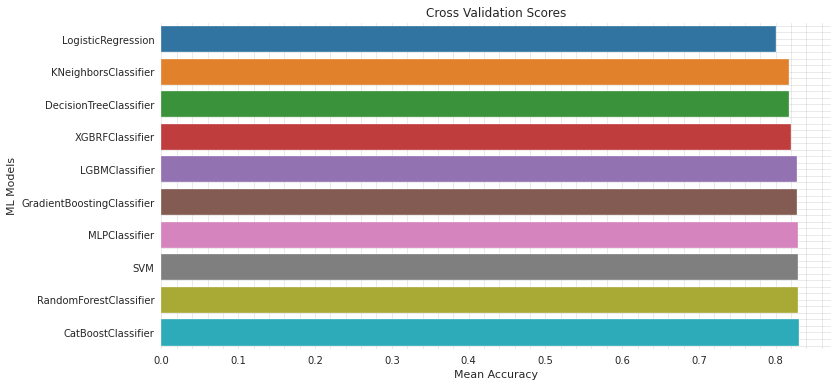

In [85]:
cv_results = pd.DataFrame({"Cross Validation Means":cv_result, 
                           "ML Models":["DecisionTreeClassifier", "SVM","RandomForestClassifier",
                                        "LogisticRegression","KNeighborsClassifier",
                                        "GradientBoostingClassifier","MLPClassifier",
                                        "XGBRFClassifier","LGBMClassifier","CatBoostClassifier"]})

results = cv_results.sort_values(['Cross Validation Means']).reset_index(drop=True)
g = sns.barplot("Cross Validation Means", "ML Models", data = results)
g.set_xlabel("Mean Accuracy")
g.set_title("Cross Validation Scores");

plt.figure(figsize=(12,6))
plt.grid(b=True, which='both', color='#999999', linestyle='-', alpha=0.2)
plt.minorticks_on()

In [76]:
cv_results 

,Cross Validation Means,ML Models
0,0.817203,DecisionTreeClassifier
1,0.828785,SVM
2,0.828870,RandomForestClassifier
3,0.800141,LogisticRegression
4,0.817090,KNeighborsClassifier
5,0.827147,GradientBoostingClassifier
6,0.828729,MLPClassifier
7,0.820452,XGBRFClassifier
8,0.827119,LGBMClassifier
9,0.830537,CatBoostClassifier


In [86]:
# we have t use for using the VotingClassifier ing : we only adding : probability=True
best_estimators[1] = SVC(C=200, gamma=0.01, probability=True,random_state=42)
best_estimators[1]

SVC(C=200, gamma=0.01, probability=True, random_state=42)

<a id = "10"></a><br>
## Ensemble Modeling

The ensemble model process was applied for 6 models that gave the best performance among the 10 machine learning classification models used. This means that for each decision, the higher probability of the decisions among the 6 models is chosen.

In [83]:
votingC = VotingClassifier(estimators = [("svc",best_estimators[1]),
                                         ("rfc",best_estimators[2]),
                                        ("gbc",best_estimators[5]),
                                         ("mlp",best_estimators[6]),
                                        ("lgb",best_estimators[8]),
                                        ("catb",best_estimators[9])], 
                                        voting = "soft", n_jobs = -1)
votingC = votingC.fit(X_train, y_train)
print(accuracy_score(votingC.predict(X_test),y_test))



0.8271186440677966


<a id = "11"></a><br>
## Prediction and Submission

Arrangements were made to be sent to the competition in Kaggle.

In [132]:
# before that we have to convert test data to standard scaler
test_scaler = scaler.transform(test.values)
test = pd.DataFrame(test_scaler, index=test.index, columns=test.columns)

In [133]:
test_survived = pd.Series(votingC.predict(test), name = "Survived").astype(int)
results = pd.concat([test_PassengerId, test_survived],axis = 1)
results.to_csv("titanic.csv", index = False)